**Loading the MPII Dataset**

In [ ]:
##For Images
!wget https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz

!tar --gunzip --extract --verbose --file=mpii_human_pose_v1.tar.gz &> /dev/null

--2022-12-27 18:54:37--  https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.206.177
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.206.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12088943206 (11G) [application/x-gzip]
Saving to: ‘mpii_human_pose_v1.tar.gz’

mpii_human_pose_v1. 100%[===================>]  11.26G  17.2MB/s    in 9m 30s  

2022-12-27 19:04:07 (20.2 MB/s) - ‘mpii_human_pose_v1.tar.gz’ saved [12088943206/12088943206]



**Splitting Into Training and Testing**

In [ ]:
import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):

  dirs = os.listdir(images_origin)

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  # Shuffle the files, deterministically
  filenames = [os.path.join(images_origin, f) for f in dirs if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
  filenames.sort()
  random.seed(42)
  random.shuffle(filenames)
  # Divide them into train/test dirs
  totalImagesSize = len(filenames)/3
  test_count = int(totalImagesSize * test_split)
  for i, file in enumerate(filenames):
    if i < test_count:
      destination = os.path.join(TEST_DIR, os.path.split(file)[1])
    else:
      destination = os.path.join(TRAIN_DIR, os.path.split(file)[1])
    shutil.copyfile(file, destination)
  print(f'Moved {test_count} of {totalImagesSize} from class "{dir}" into test.')

In [ ]:
dataset_in = '/content/images'
# if not os.path.isdir(dataset_in):
#   raise Exception("dataset_in is not a valid directory")
dataset_out = 'split_' + dataset_in
split_into_train_test(dataset_in, dataset_out, test_split=0.2)
IMAGES_ROOT = dataset_out

Moved 1665 of 8328.0 from class "<built-in function dir>" into test.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading the Model**

In [ ]:
# allows us to make detection

# Lightning Model for Faster Detection
interpreter_Lightning = tf.lite.Interpreter(model_path = '/content/drive/MyDrive/lite-model_movenet_singlepose_lightning_3.tflite') 

# Thunder Model for Better Accuracy
interpreter_Thunder = tf.lite.Interpreter(model_path = '/content/drive/MyDrive/lite-model_movenet_singlepose_thunder_3.tflite') 

# when working with tflite model
interpreter_Lightning.allocate_tensors()
interpreter_Thunder.allocate_tensors()

In [ ]:
# For connection of edges
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [ ]:
def movnet(input_Image,isLightning):

  image = cv2.imread(input_Image)
  plt.imshow(image)

  image.shape

  # Resize and pad the image to keep the aspect ratio and fit the expected size.
  input_image = tf.expand_dims(image, axis=0)

  if isLightning:
    input_size = 192 # for lightning model

  else:
    input_size = 256 # for thunder model

  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

  input_image = tf.cast(input_image,dtype = tf.float32)
  # Above line creates a tensor

  # For showing image from a tensor we have to convert it to int first
  # plt.imshow(tf.cast(np.squeeze(input_image),dtype = tf.int32))

  # Input and Output
  if isLightning:
    input_details = interpreter_Lightning.get_input_details() 
    output_details = interpreter_Lightning.get_output_details() 
    # Make predictions 
    interpreter_Lightning.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter_Lightning.invoke()
    keypoints_with_scores = interpreter_Lightning.get_tensor(output_details[0]['index'])

  else:
    input_details = interpreter_Thunder.get_input_details() 
    output_details = interpreter_Thunder.get_output_details() 
    # Make predictions 
    interpreter_Thunder.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter_Thunder.invoke()
    keypoints_with_scores = interpreter_Thunder.get_tensor(output_details[0]['index'])


  # Above line gives us the keypoints for our image

  draw_connections(image, keypoints_with_scores, EDGES, 0.4)
  draw_keypoints(image, keypoints_with_scores, 0.4)
  plt.imshow(image)

  # cv2.imshow('MoveNet Lightning', input_image)


**Drawing Keypoints**

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    # Above line allow us to get the location of the keypoint depending on our current image original size
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

**Drawing Connections**

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

**Comparing Lightning and Thunder Models**

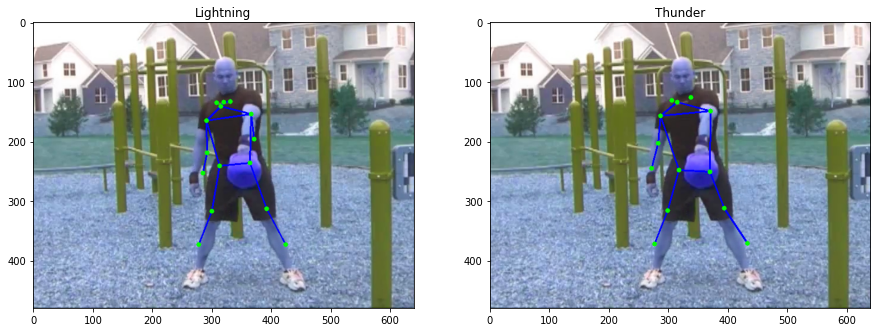

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

plt.subplot(1,2,1)
plt.title('Lightning')
movnet('/content/split_/content/images/test/010587432.jpg',True)
plt.subplot(1,2,2)
plt.title('Thunder')
movnet('/content/split_/content/images/test/010587432.jpg',False)

# plt.figure(figsize=(12, 8))

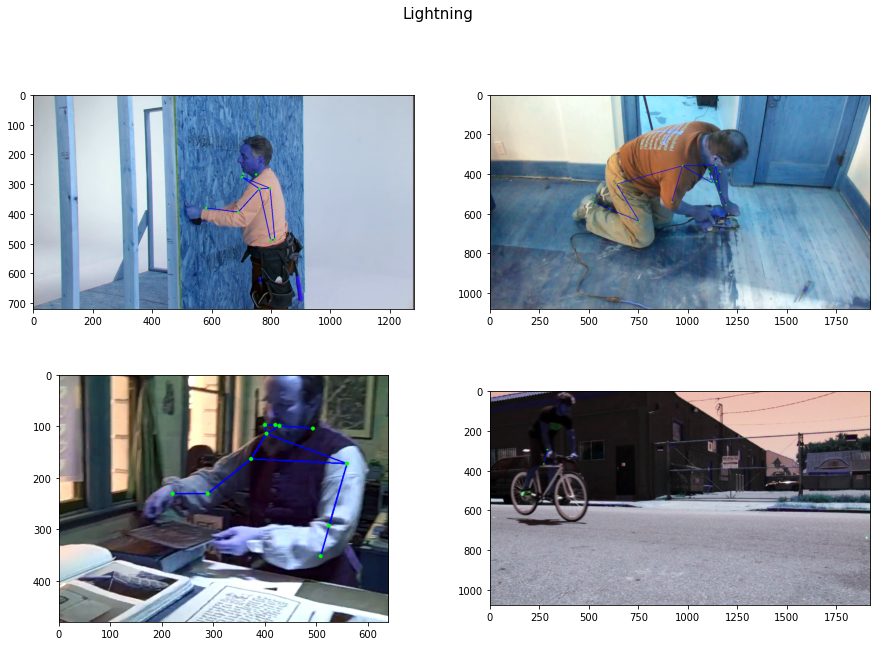

In [ ]:
dirpath = '/content/split_/content/images/train/'
filenames = random.sample(os.listdir(dirpath), 4)
row = 2
column = 2
plotno = 1
fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle("Lightning", fontsize=15)
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    plt.subplot(row,column,plotno)
    plotno += 1
    movnet(srcpath,True)

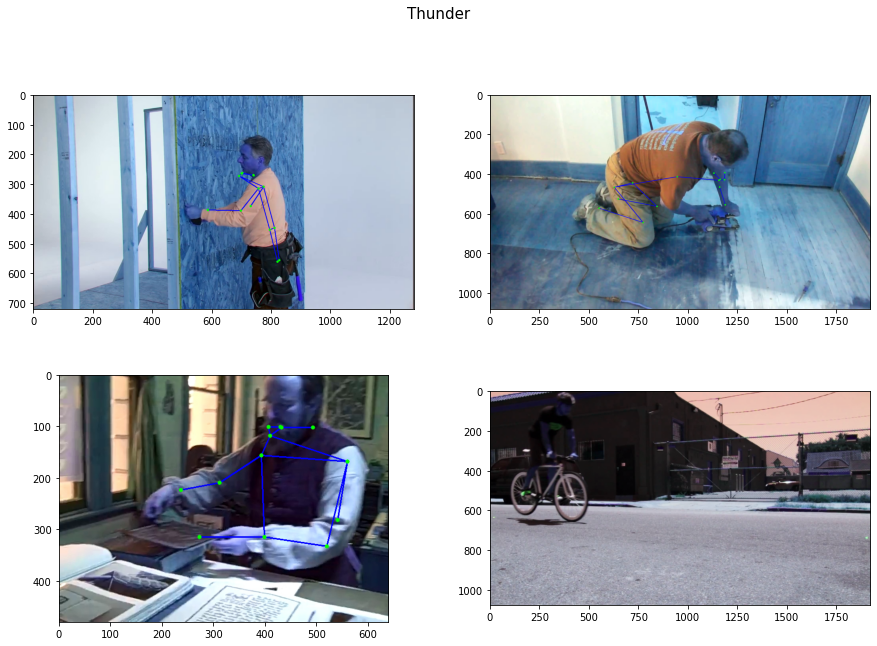

In [ ]:
row = 2
column = 2
plotno = 1
fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle("Thunder", fontsize=15)
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    plt.subplot(row,column,plotno)
    plotno += 1
    movnet(srcpath,False)

**Importing the VTON Dataset**

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fahadabdullah1","key":"15178a95a9e1b7776b0ae16bbd19d11d"}'}

In [3]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download 'rkuo2000/viton-dataset'

 98% 617M/629M [00:03<00:00, 234MB/s]
100% 629M/629M [00:03<00:00, 199MB/s]


In [6]:
!unzip viton-dataset.zip &> /dev/null

In [7]:
import pandas as pd
import numpy as np
import io
import matplotlib 
from matplotlib import pyplot as plt
import cv2
import random
import os
import json

**Visualizing Dataset**

In [345]:
def visualize_poses(filename):
      file_path = f'/content/ACGPN_TrainData/train_pose/{filename}_keypoints.json'

      with open(file_path) as json_file:
        data = json.load(json_file)

        data = data['people'][0]['pose_keypoints']

        pose_keypoints_array = np.array(data).reshape(-1,3)

        pose_keypoints_array_original = pose_keypoints_array.copy()

        fig, ax = plt.subplots(1, 2, figsize=(15,10))

        fig.suptitle("Original vs After Preprocessing", fontsize=15)

        i=0
        for x,y,z in pose_keypoints_array_original: 
          srcpath = f'/content/ACGPN_TrainData/train_img/{filename}.jpg'
          image = cv2.imread(f'{srcpath}')
          plt.subplot(1,2,1)
          plt.imshow(image)
          plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
          plt.text(x, y, str(i), color='r', fontsize=10)
          i+=1

        pose_keypoints_array = np.delete(pose_keypoints_array, [0,1,9,12,14,15,16,17],0) #Deleting the Facial and Lower-Body Landmarks

        rows = np.where(pose_keypoints_array[:,pose_keypoints_array.shape[1]-1] == 0)

        pose_keypoints_array = np.delete(pose_keypoints_array, rows[0],0) #Deleting the misclassified poses

      i=0
      for x,y,z in pose_keypoints_array: 
          srcpath = f'/content/ACGPN_TrainData/train_img/{filename}.jpg'
          image = cv2.imread(f'{srcpath}')
          plt.subplot(1,2,2)
          plt.imshow(image)
          plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
          plt.text(x, y, str(i), color='r', fontsize=10)
          i+=1

      return pose_keypoints_array_original

Body poses according to vton dataset
<br>
'2' for right shoulder
<br>
'3' for right elbow
<br>
'4' for right hand
<br>
'5' for left shoulder
<br>
'6' for left elbow
<br>
'7' for left hand
<br>
'8' for right hip
<br>
'11' for left hip



<ipython-input-345-0a4891769483>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-345-0a4891769483>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


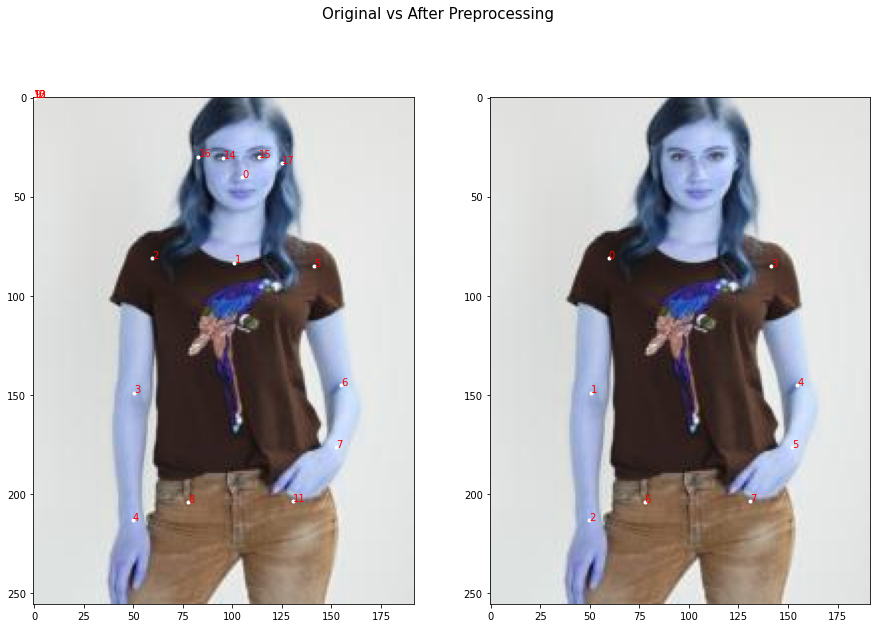

In [346]:
dirpath = '/content/ACGPN_TrainData/train_img'
randomfile = random.sample(os.listdir(dirpath), 1)
randomfilename = randomfile[0][0:8]

poses_actual = visualize_poses(randomfilename)

In [134]:
!pip install mediapipe &> /dev/null
import mediapipe as mp

In [11]:
import tensorflow as tf

In [12]:
mp_drawing = mp.solutions.drawing_utils     #helps in drawing detections
mp_pose = mp.solutions.pose   #importing model

**Detections using Mediapipe**

In [321]:
def mediapipe_detection(image):

  # Setting mediapipe instance
  with mp_pose.Pose(min_detection_confidence=0.7,min_tracking_confidence=0.7) as pose:

      # Recolor image for mediapipe
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

      # plt.imshow()
      image.flags.writeable = False  # saving memory

      # Make detection
      results = pose.process(image)

      # Recolor image for opencv
      image.flags.writeable = True
      image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)

      h, w = image.shape[:2]

      # Use lm and lmPose as representative of the following methods.
      lm = results.pose_landmarks
      lmPose  = mp_pose.PoseLandmark

      predictions = []

      if lm != None:

          # Right shoulder.
          r_shldr_x = int(lm.landmark[lmPose.RIGHT_SHOULDER].x * w)
          r_shldr_y = int(lm.landmark[lmPose.RIGHT_SHOULDER].y * h)

          predictions.append([r_shldr_x,r_shldr_y])

          # Right elbow.
          r_elbow_x = int(lm.landmark[lmPose.RIGHT_ELBOW].x * w)
          r_elbow_y = int(lm.landmark[lmPose.RIGHT_ELBOW].y * h)

          predictions.append([r_elbow_x,r_elbow_y])

          # Right wrist.
          r_wrist_x = int(lm.landmark[lmPose.RIGHT_WRIST].x * w)
          r_wrist_y = int(lm.landmark[lmPose.RIGHT_WRIST].y * h)

          predictions.append([r_wrist_x,r_wrist_y])

          # Left shoulder.
          l_shldr_x = int(lm.landmark[lmPose.LEFT_SHOULDER].x * w)
          l_shldr_y = int(lm.landmark[lmPose.LEFT_SHOULDER].y * h)

          predictions.append([l_shldr_x,l_shldr_y])
    
          # Left elbow.
          l_elbow_x = int(lm.landmark[lmPose.LEFT_ELBOW].x * w)
          l_elbow_y = int(lm.landmark[lmPose.LEFT_ELBOW].y * h)

          predictions.append([l_elbow_x,l_elbow_y])

          # Left wrist.
          l_wrist_x = int(lm.landmark[lmPose.LEFT_WRIST].x * w)
          l_wrist_y = int(lm.landmark[lmPose.LEFT_WRIST].y * h)

          predictions.append([l_wrist_x,l_wrist_y])

          # Right hip.
          r_hip_x = int(lm.landmark[lmPose.RIGHT_HIP].x * w)
          r_hip_y = int(lm.landmark[lmPose.RIGHT_HIP].y * h)

          predictions.append([r_hip_x,r_hip_y])

          # Left hip.
          l_hip_x = int(lm.landmark[lmPose.LEFT_HIP].x * w)
          l_hip_y = int(lm.landmark[lmPose.LEFT_HIP].y * h)

          predictions.append([l_hip_x,l_hip_y])

      # Render detections
      mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_pose.POSE_CONNECTIONS)

      # fig, ax = plt.subplots(1, 2, figsize=(15,10))

      # fig.suptitle("Mediapipe Output", fontsize=15)

      # plt.subplot(1,2,1)
      # plt.imshow(image)

      black_background = np.zeros(image.shape , np.uint8)

       # Replace the `img` with `black` while drawing the landmarks
      mp_drawing.draw_landmarks(black_background,results.pose_landmarks,mp_pose.POSE_CONNECTIONS)

      # plt.subplot(1,2,2)
      # plt.imshow(black_background)

      return image,black_background,predictions

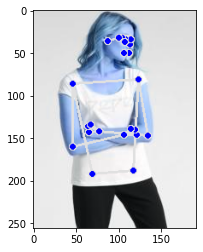

In [329]:
srcpath = f'/content/ACGPN_TrainData/train_img/{randomfilename}.jpg'
image: np.array = cv2.imread(f'{srcpath}')

media_output,media_output_black,poses_predictions = mediapipe_detection(image)

plt.imshow(media_output)

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
# allows us to make detection

# Lightning Model for Faster Detection
interpreter_Lightning = tf.lite.Interpreter(model_path = '/content/drive/MyDrive/lite-model_movenet_singlepose_lightning_3.tflite') 

# Thunder Model for Better Accuracy
interpreter_Thunder = tf.lite.Interpreter(model_path = '/content/drive/MyDrive/lite-model_movenet_singlepose_thunder_3.tflite') 

# when working with tflite model
interpreter_Lightning.allocate_tensors()
interpreter_Thunder.allocate_tensors()

In [296]:
# For connection of edges
EDGES = {
    # (0, 1): 'm',
    # (0, 2): 'c',
    # (1, 3): 'm',
    # (2, 4): 'c',
    # (0, 5): 'm',
    # (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    # (11, 13): 'm',
    # (13, 15): 'm',
    # (12, 14): 'c',
    # (14, 16): 'c'
}

**Comparing Different Models**

In [326]:
def movnet(input_Image,isLightning):

  image = cv2.imread(input_Image)
  # plt.imshow(image)

  image.shape

  # Resize and pad the image to keep the aspect ratio and fit the expected size.
  input_image = tf.expand_dims(image, axis=0)

  if isLightning:
    input_size = 192 # for lightning model

  else:
    input_size = 256 # for thunder model

  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

  input_image = tf.cast(input_image,dtype = tf.float32)
  # Above line creates a tensor

  # For showing image from a tensor we have to convert it to int first
  # plt.imshow(tf.cast(np.squeeze(input_image),dtype = tf.int32))

  # Input and Output
  if isLightning:
    input_details = interpreter_Lightning.get_input_details() 
    output_details = interpreter_Lightning.get_output_details() 
    # Make predictions 
    interpreter_Lightning.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter_Lightning.invoke()
    keypoints_with_scores = interpreter_Lightning.get_tensor(output_details[0]['index'])

  else:
    input_details = interpreter_Thunder.get_input_details() 
    output_details = interpreter_Thunder.get_output_details() 
    # Make predictions 
    interpreter_Thunder.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter_Thunder.invoke()
    keypoints_with_scores = interpreter_Thunder.get_tensor(output_details[0]['index'])

  pose_predicted = draw_keypoints(image, keypoints_with_scores, 0)
  draw_connections(image, keypoints_with_scores, EDGES, 0.4)
  # plt.imshow(image)

  return pose_predicted

  # 5 for left shoulder
  # 6 for right shoulder
  # 7 for left elbow
  # 8 for right elbow
  # 9 for left hand
  # 10 for right hand
  # 11 for left hip
  # 12 for right hip

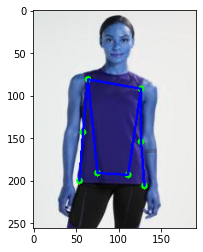

In [307]:
srcpath = f'/content/ACGPN_TrainData/train_img/{randomfilename}.jpg'

pose_predicted = movnet(srcpath,False)

In [327]:
i = 0
dirpath = '/content/ACGPN_TrainData/train_img'
files = []
error_rate_movnet_thunder = []
error_rate_movnet_lightning = []
error_rate_mediapipe = []
images = []

while i < 50:

    randomfile = random.sample(os.listdir(dirpath), 1)
    randomfilename = randomfile[0][0:8]

    if randomfilename not in files:
        poses_actual = visualize_poses(randomfilename)

        srcpath = f'/content/ACGPN_TrainData/train_img/{randomfilename}.jpg'

        images.append(srcpath)

        file_path = f'/content/ACGPN_TrainData/train_pose/{randomfilename}_keypoints.json'

        image: np.array = cv2.imread(f'{srcpath}')

        poses_predictions_movnet_thunder = movnet(srcpath,False)

        poses_predictions_movnet_lightning = movnet(srcpath,True)

        indexes = [2,3,4,5,6,7,8,11]

        # indexes_movnet = [5,6,7,8,9,10,11,12]

        media_output,media_output_black,poses_predictions_mediapipe = mediapipe_detection(image)

        # indexes_mediapipe = [2,3,4,5,6,7,8,11]

        poses_actual_original = poses_actual.copy()

        poses_actual = []
        differences_movnet_thunder = []
        differences_movnet_lightning = []
        differences_mediapipe = []
        squares_difference_movnet_thunder = []
        squares_difference_movnet_lightning = []
        squares_difference_mediapipe = []

        for j in range(len(poses_actual_original)):
            if j in indexes:
                poses_actual.append(poses_actual_original[j])

        for k in range(len(poses_predictions_movnet_thunder)):
            differences_movnet_thunder.append(poses_predictions_movnet_thunder[k][0]-poses_actual[k][0] + poses_predictions_movnet_thunder[k][1]-poses_actual[k][1])
            squares_difference_movnet_thunder.append(differences_movnet_thunder[k]**2)

        error_rate_movnet_thunder.append(np.sqrt(np.mean(squares_difference_movnet_thunder)))

        for k in range(len(poses_predictions_movnet_lightning)):
            differences_movnet_lightning.append(poses_predictions_movnet_lightning[k][0]-poses_actual[k][0] + poses_predictions_movnet_lightning[k][1]-poses_actual[k][1])
            squares_difference_movnet_lightning.append(differences_movnet_lightning[k]**2)

        error_rate_movnet_lightning.append(np.sqrt(np.mean(squares_difference_movnet_lightning)))

        for k in range(len(poses_predictions_mediapipe)):
            differences_mediapipe.append(poses_predictions_mediapipe[k][0]-poses_actual[k][0] + poses_predictions_mediapipe[k][1]-poses_actual[k][1])
            squares_difference_mediapipe.append(differences_mediapipe[k]**2)

        error_rate_mediapipe.append(np.sqrt(np.mean(squares_difference_mediapipe)))

        i += 1

    else:
        i = i

(0.0, 214.5510460312184)

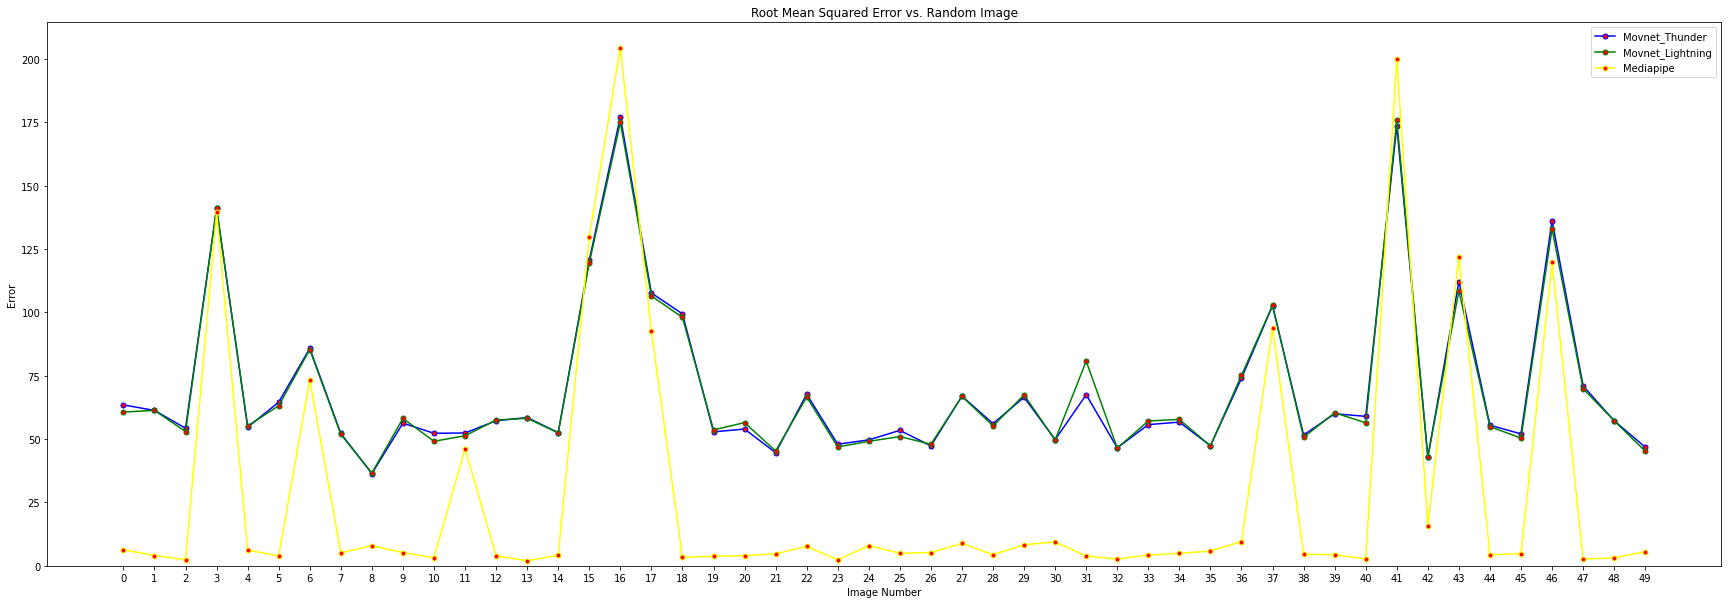

In [328]:
fig1 = plt.figure(figsize=(30, 10))

plt.plot(range(0,50),error_rate_movnet_thunder,color='blue', marker='o',
 markerfacecolor='red', markersize=5,label='Movnet_Thunder')
plt.plot(range(0,50),error_rate_movnet_lightning,color='green', marker='o',
 markerfacecolor='red', markersize=5,label='Movnet_Lightning')
plt.plot(range(0,50),error_rate_mediapipe,color='yellow', marker='o',
 markerfacecolor='red', markersize=5,label='Mediapipe')
plt.xticks(np.arange(0, 50, 1))
plt.title('Root Mean Squared Error vs. Random Image')
plt.xlabel('Image Number')
plt.ylabel('Error')
plt.legend()
plt.ylim([0, max(error_rate_mediapipe)+10])

Text(0.5, 1.0, 'Lightning Model')

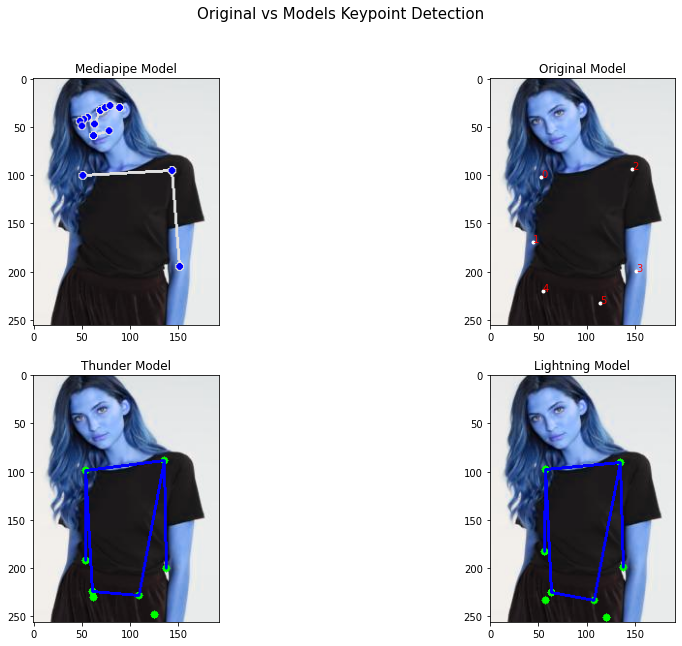

In [317]:
max_error_index = error_rate_mediapipe.index(max(error_rate_mediapipe))

image = cv2.imread(f'{images[max_error_index]}')

media_output,media_output_black,poses_predictions = mediapipe_detection(image)

fig, ax = plt.subplots(1, 2, figsize=(15,10))

fig.suptitle("Original vs Models Keypoint Detection", fontsize=15)

plt.subplot(2,2,1)
plt.imshow(media_output)
plt.title('Mediapipe Model')

max_error_image = images[max_error_index][35:43]

plt.subplot(2,2,2)

poses_actual = visualize_poses(images[max_error_index][35:43])
plt.title('Original Model')

srcpath = f'/content/ACGPN_TrainData/train_img/{max_error_image}.jpg'

plt.subplot(2,2,3)
poses_predictions_movnet_thunder = movnet(srcpath,False)
plt.title('Thunder Model')

plt.subplot(2,2,4)
poses_predictions_movnet_lightning = movnet(srcpath,True)
plt.title('Lightning Model')

In [277]:
def draw_keypoints(frame, keypoints, confidence_threshold):

    keypoints = keypoints[0][0][5:13]
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    # Above line allow us to get the location of the keypoint depending on our current image original size
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

    return shaped

In [278]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

**Connected Component Analysis**

In [330]:
def CCA(imageMatrix):

      newMatrix = np.full((imageMatrix.shape[0]+2,imageMatrix.shape[1]+2),0,np.uint8)

      for i in range(newMatrix.shape[0]-2):
          for j in range(newMatrix.shape[1]-2):
              newMatrix[i+1,j+1] = imageMatrix[i,j]

      #Defining threshold
      for i in range(1,newMatrix.shape[0]-1):
          for j in range(1,newMatrix.shape[1]-1):
              if newMatrix[i,j] > 127:
                  newMatrix[i,j] = 255
              else:
                  newMatrix[i,j] = 0

      plt.imshow(newMatrix)

      label = 0
      obj = 0
      pos = 0
      eq_list = []
      newlist = []

      label_matrix = np.zeros((newMatrix.shape[0],newMatrix.shape[1]),dtype=int)

      #Making Label Matrix
      for i in range(1, newMatrix.shape[0]-1):
          for j in range(1, newMatrix.shape[1]-1):
              if newMatrix[i, j] == 255:
                  count = 0
                  list = []
                  if newMatrix[i, j - 1] != 255 and newMatrix[i - 1, j - 1] != 255 and newMatrix[i - 1, j] != 255 and newMatrix[i - 1, j + 1] != 255:
                      label += 1
                      label_matrix[i, j] = label
                      eq_list.append([label,label])
                  if newMatrix[i, j - 1] == 255:
                      pos = 1
                      count += 1
                      list.append(label_matrix[i, j - 1])
                  if newMatrix[i - 1, j - 1] == 255:
                      pos = 2
                      count += 1
                      list.append(label_matrix[i - 1, j - 1])
                  if newMatrix[i - 1, j] == 255:
                      pos = 3
                      count += 1
                      list.append(label_matrix[i - 1, j])
                  if newMatrix[i - 1, j + 1] == 255:
                      pos = 4
                      count += 1
                      list.append(label_matrix[i - 1, j + 1])
                  if pos == 1 and count == 1:
                      label_matrix[i, j] = label_matrix[i, j - 1]
                  if pos == 2 and count == 1:
                      label_matrix[i, j] = label_matrix[i - 1, j - 1]
                  if pos == 3 and count == 1:
                      label_matrix[i, j] = label_matrix[i - 1, j]
                  if pos == 4 and count == 1:
                      label_matrix[i, j] = label_matrix[i - 1, j + 1]
                  if count > 1:
                      minimum = min(list)
                      for k in range(len(list)):
                          if minimum == list[k]:
                              label_matrix[i,j] = minimum
                          else:
                              label_matrix[i,j] = min(list)
                              #Updating Equivalency list
                              for l in range(len(eq_list)):
                                  if eq_list[l][1] > min(list) and eq_list[l][1] in list:
                                      eq_list[l][1] = min(list)

      #Updating Label Matrix
      for i in range(1,label_matrix.shape[0]-1):
          for j in range(1,label_matrix.shape[1]-1):
              for k in range(len(eq_list)):
                  if label_matrix[i,j] == eq_list[k][0]:
                      label_matrix[i,j] = eq_list[k][1]

      #Updating no of Objects
      for i in range(1,label_matrix.shape[0]-1):
          for j in range(1,label_matrix.shape[1]-1):
              if label_matrix[i,j] != 0 and label_matrix[i,j] not in newlist:
                  minimum = label_matrix[i,j]
                  newlist.append(minimum)
                  obj += 1

      # np.set_printoptions(threshold=np.inf)
      # print(label_matrix)

      plt.subplot(1,2,2)
      plt.imshow(label_matrix)
      
      return label_matrix

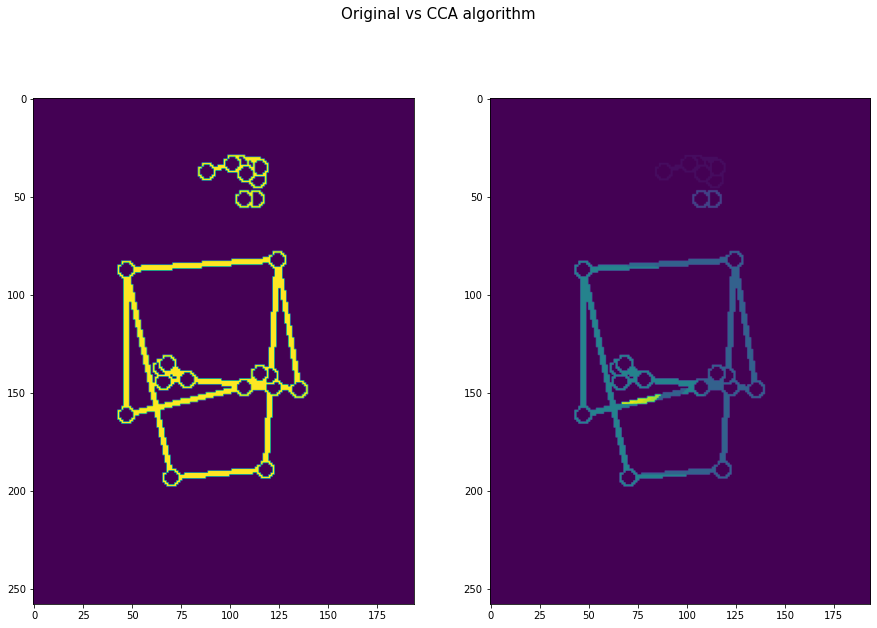

In [332]:
X_train_gray = cv2.cvtColor(media_output_black, cv2.COLOR_BGR2GRAY)

# X_train_gray = cv2.merge([X_train_gray,X_train_gray,X_train_gray])
# X_train_gray = np.expand_dims(media_output, axis=-1)

fig, ax = plt.subplots(1, 2, figsize=(15,10))

fig.suptitle("Original vs CCA algorithm", fontsize=15)

plt.subplot(1,2,1)
label_matrix = CCA(X_train_gray)

**Dilation of Image**

In [333]:
def dilation(image,structuring_element):
    padding = int(structuring_element.shape[0] / 2)
    image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT,value=0)
    threshold_Image = np.full((image.shape[0], image.shape[1]), 0, np.uint8)
    dilated_Image_Padded = np.full((image.shape[0], image.shape[1]), 0, np.uint8)
    dilated_Image = np.full((dilated_Image_Padded.shape[0] - 2*padding, dilated_Image_Padded.shape[1] - 2*padding), 0, np.uint8)
    neighbours_Matrix = np.full((structuring_element.shape[0], structuring_element.shape[1]), 0, np.uint8)
    for i in range(padding,image.shape[0]-padding):
        for j in range(padding,image.shape[1]-padding):
            if image[i, j] > 127:
                threshold_Image[i, j] = 255

    for i in range(padding,threshold_Image.shape[0]-padding):
        for j in range(padding,threshold_Image.shape[1]-padding):
            count = 0
            neighbours_Matrix[:,:] = threshold_Image[i - padding:i + padding+1, j - padding:j + padding+1]
            for k in range(neighbours_Matrix.shape[0]):
                for l in range(neighbours_Matrix.shape[1]):
                    if neighbours_Matrix[k,l] == 255 and structuring_element[k,l] == 255:
                        dilated_Image_Padded[i,j] = 255

    for i in range(padding,dilated_Image_Padded.shape[0]-padding):
        for j in range(padding,dilated_Image_Padded.shape[1]-padding):
            dilated_Image[i-padding,j-padding] = dilated_Image_Padded[i,j]

    return dilated_Image

In [334]:
structuring_Element_Size = int(input('Enter size for opening structuring element : '))
structuring_Element = np.full((structuring_Element_Size,structuring_Element_Size),0,np.uint8)

for i in range(structuring_Element_Size):
    for j in range(structuring_Element_Size):
        structuring_Element[i,j] = 255

resultant_Dilation_Image = dilation(X_train_gray,structuring_Element)

Enter size for opening structuring element : 3


(258, 194)


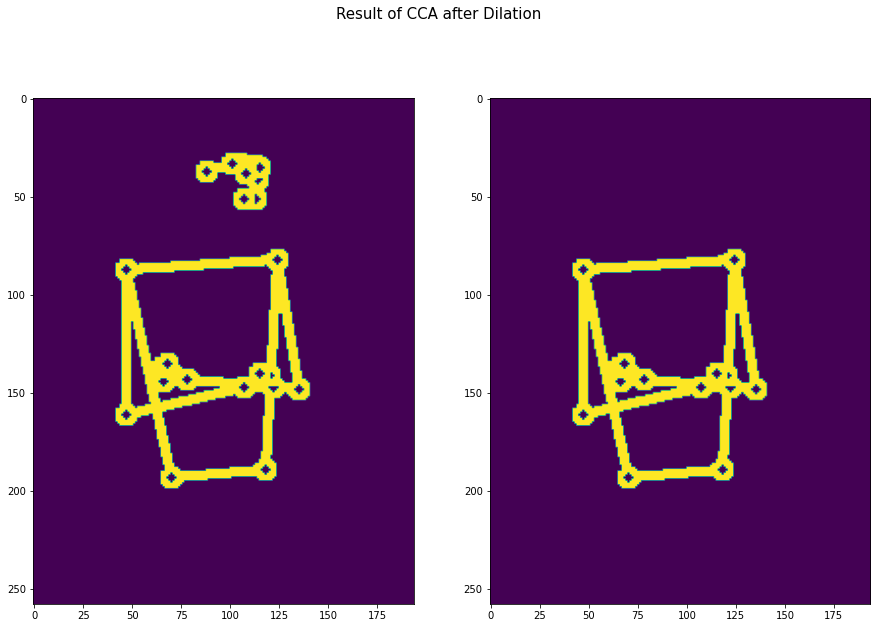

In [350]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

fig.suptitle("Result of CCA after Dilation", fontsize=15)

plt.subplot(1,2,1)
plt.imshow(resultant_Dilation_Image)

label_matrix = CCA(resultant_Dilation_Image)

print(label_matrix.shape)

for i in range(label_matrix.shape[0]):
    for j in range(label_matrix.shape[1]):
        if label_matrix[i,j] == 1:
            label_matrix[i,j] = 0
        elif label_matrix[i,j] != 0:
            structural_element = label_matrix[i,j]

plt.imshow(label_matrix)